In [426]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext Cython
%load_ext autoreload
%autoreload 2

from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['savefig.dpi'] = 1.5 * matplotlib.rcParams['savefig.dpi']

import numpy as np
import scipy
import scipy.misc as scmisc
import scipy.special as ss
import scipy.linalg as sl
import scipy.integrate as si
import scipy.interpolate as interp
import scipy.constants as sc
import scipy.optimize as sopt
import scipy.stats as scistats
import sys,os,glob,h5py
import cPickle as pickle

import PTMCMCSampler as PAL
import libstempo as T2
import libstempo.plot as LP

import NX01_psr
import NX01_datafile

try:
    from IPython.core.display import clear_output
    have_ipython = True
except ImportError:
    have_ipython = False

Msol = 1.98855*10.0**30.0

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
parpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/'
timpath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/tim/'
noisepath = '/Users/staylor/Research/NANOGrav/NANOGrav_9y/noisefiles/'

In [11]:
parfiles = sorted(glob.glob(parpath+'*.par'))
timfiles = sorted(glob.glob(timpath+'*.tim'))

In [12]:
parfiles = [x for x in parfiles 
            if x!='/Users/staylor/Research/NANOGrav/NANOGrav_9y/par/J1713+0747_NANOGrav_9yv1.gls.par' ]

In [13]:
noisefiles = sorted(glob.glob(noisepath+'*.txt'))

In [18]:
len(parfiles), len(timfiles), len(noisefiles)

(37, 37, 37)

## This code block is a one-time deal to make par files stripped off EFACS, EQUADS, and ECORRs

In [394]:
stripped_pars = list(parfiles)

In [398]:
for ii in range(len(stripped_pars)):
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.gls.par', '9yv1.gls.strip.par')
    stripped_pars[ii] = stripped_pars[ii].replace('9yv1.t2.gls.par', '9yv1.t2.gls.strip.par')

In [400]:
# make some idealised nanograv par files...no DMX, EFAC, EQUAD, etc.
for ii in range(len(stripped_pars)):
    os.system('awk \'($1 !~ /T2EFAC/ && $1 !~ /T2EQUAD/ && $1 !~ /ECORR/ && $1 !~ /RNAMP/ && $1 !~ /RNIDX/ ) {{print $0}} \' {0} > {1}'.format(parfiles[ii],stripped_pars[ii]))

## Now moving on to processing these pulsars

In [401]:
parfiles = sorted(glob.glob(parpath+'*.strip.par'))

In [435]:
#######################################
# PASSING THROUGH TEMPO2 VIA libstempo
#######################################

t2psr = []
for ii in range(len(parfiles)):
#for ii in range(1):
    
    t2psr.append( T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii]) )
    t2psr[ii].fit(iters=3)
    
    if np.any(np.isfinite(t2psr[ii].residuals())==False)==True:
        t2psr[ii] = T2.tempopulsar(parfile = parfiles[ii], timfile = timfiles[ii])
                 
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(parfiles))
    sys.stdout.flush()
                 

37 of 37


<Container object of 3 artists>

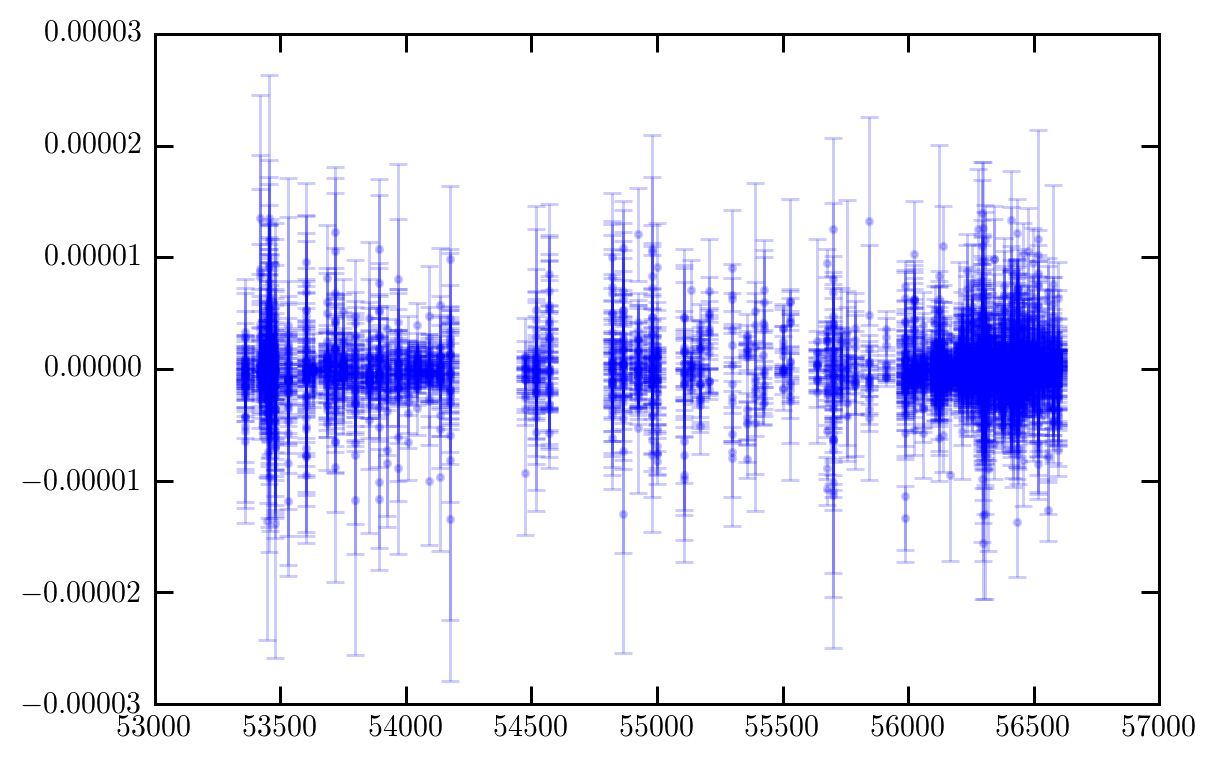

In [436]:
# Check out some plots if you want
plt.errorbar(t2psr[0].toas(),t2psr[0].residuals(),1e-6*t2psr[0].toaerrs,fmt='.',alpha=0.2)

In [437]:
t2psr[0].toaerrs

array([ 1.277,  0.858,  0.897, ...,  1.11 ,  0.657,  2.613])

In [438]:
psr = [NX01_psr.PsrObj(p) for p in t2psr]
[p.grab_all_vars(jitterbin=1.0) for p in psr] # according to the 9 year paper,
                                              # the jitterbin used is 1s

--> Processing B1855+09
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1937+21
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Finished checks.
--> Performing SVD of design matrix for stabilization...
--> Done reading in pulsar :-) 

--> Processing B1953+29
--> Grabbed the pulsar position.
--> Processed all relevant flags plus associated locations.
--> Sorted data.
--> Computed quantization matrix.
--> Excized epochs without jitter.
--> Checking TOA sorting and quantization...
True
True
...Fin

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [439]:
for ii in range(len(psr)):
    psr[ii].parfile = parfiles[ii] 
    psr[ii].timfile = timfiles[ii]
    psr[ii].noisefile = noisefiles[ii]

In [440]:
for ii,p in enumerate(psr):
    df = NX01_datafile.DataFile(p.name+'.hdf5')
    df.addTempoPulsar(p)
    
    clear_output()
    print '\r', '{0} of {1}'.format(ii+1,len(psr))
    sys.stdout.flush()

37 of 37
